<a href="https://colab.research.google.com/github/mrinaaall/OkCupid/blob/main/OkCupid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
missing_values = ["n/a", "na", "--", '-1', "NaN"]
profile_data = pd.read_csv('/content/drive/MyDrive/profiles.csv', encoding = 'utf8', na_values = missing_values)

In [4]:
profile_data.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [5]:
profile_data.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,NaN,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000.0,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,NaN,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,white,71.0,20000.0,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN,"asian, black, other",66.0,NaN,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


As evident from the the cell above, we can see that there are missing values which can be handled later. In addition to that the text data isn't clean and requires preprocessing before we move forward with any EDA or recommendation modeling. 

In [6]:
# Eliminating the Chained Assignment error.
pd.set_option('mode.chained_assignment', None)

Handling missing values:

Approach 1: Drop all missing values and move forward with preprocessing, feature engineering and modeling. 
Approach 2: Handle quantitative missing values by imputing mean and handle categorical missing values by replacing NaN with mode values. This might lead to some bias, but that can be handled later.

Since I was a little short on time, I decided to move ahead with Approach 1.. leaving room for improvement by coming back to Approach 2 later.

In [7]:
profile_data = profile_data.dropna()

-----------------------

Preprocessing and Feature Engineering (Demographics):

In [8]:
'''
last_online: last active date and time of a user

1. Create a date-time object.
2. Split DATETIME instance of last_online into two separate columns : 'Date' and 'Time'.
3. Split Date into Day, Month and Year for a more specific breakdown of data to obtain the best insights.
'''
profile_data['last_online'] = pd.to_datetime(profile_data.last_online, format='%Y-%m-%d-%H-%M')

# Splitting DATETIME instance of last_online into Date AND Time.
profile_data['last_date_online'] = pd.to_datetime(profile_data['last_online']).dt.date
profile_data['last_time_online'] = pd.to_datetime(profile_data['last_online']).dt.time

# Splitting date into Day, Month, and Year.
profile_data['year'] = pd.to_datetime(profile_data['last_date_online']).dt.year
profile_data['month'] = pd.to_datetime(profile_data['last_date_online']).dt.month
profile_data['day'] = pd.to_datetime(profile_data['last_date_online']).dt.day

--------------------------------------

In [9]:
'''
location: gives a users location but with city and state

1. Separate the feature 'location' into two new features : City and State.
2. DROP State (later in the cells below), since this data is for JUST California users.
'''
location_separated = profile_data["location"].str.split(", ", n = 1, expand = True)
profile_data['city'] = location_separated[0]
profile_data['state'] = location_separated[1]

-------------------------------------------

In [10]:
'''
Retaining the religion eliminating additional information to keep it specific to just religion values
'''
profile_data['religion'] = profile_data['religion'].str.split(' ').str[0]

---------------------

In [11]:
'''
Retaining JUST the zodiac sign eliminating additional information.
'''
profile_data['sign'] = profile_data['sign'].str.split(' ').str[0]

----------------

In [12]:
'''
speaks: languages that a user speaks

1. Explode the feature 'language' into multiple columns - each column containing one language that they speak.
2. Convert it to TYPE String.
3. Eliminate 'fluency' from languages for a base model.
Future Work: Fluency can definitely be weighed in later to recommend profiles based on fluency levels.
'''
languages_separated = profile_data['speaks'].str.split(", ", n = 5, expand = True)

profile_data['language_1'] = languages_separated[0]
profile_data['language_2'] = languages_separated[1]
profile_data['language_3'] = languages_separated[2]
profile_data['language_4'] = languages_separated[3]
profile_data['language_5'] = languages_separated[4]

'''
Converting type to STRING:
'''
profile_data['language_1']=profile_data['language_1'].apply(str)
profile_data['language_2']=profile_data['language_2'].apply(str)
profile_data['language_3']=profile_data['language_3'].apply(str)
profile_data['language_4']=profile_data['language_4'].apply(str)
profile_data['language_5']=profile_data['language_5'].apply(str)


# Eliminating fluency levels in languages to obtain one single language"
# Importing re package for using regular expressions 
import re 
  
# Function to clean the names 
def language_names(language_name): 
    # Search for opening bracket in the name followed by any characters repeated any number of times 
    if re.search('\(.*', language_name): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('\(.*', language_name).start() 
  
        # return the cleaned name 
        return language_name[:pos] 
  
    else: 
        # if clean up needed return the same name 
        return language_name 
          
# Updating dataframes with clean text.
profile_data['language_1'] = profile_data['language_1'].apply(language_names) 
profile_data['language_2'] = profile_data['language_2'].apply(language_names) 
profile_data['language_3'] = profile_data['language_3'].apply(language_names) 
profile_data['language_4'] = profile_data['language_4'].apply(language_names) 
profile_data['language_5'] = profile_data['language_5'].apply(language_names) 

# Getting rid of SPACE post eliminating FLUENCY.
profile_data['language_1'] = profile_data['language_1'].str.replace(" ", "")
profile_data['language_2'] = profile_data['language_2'].str.replace(" ", "")
profile_data['language_3'] = profile_data['language_3'].str.replace(" ", "")
profile_data['language_4'] = profile_data['language_4'].str.replace(" ", "")
profile_data['language_5'] = profile_data['language_5'].str.replace(" ", "")

---------

In [13]:
'''
1. Clean the column offspring by eliminating (characters &rsquo;) from text.
'''
profile_data["offspring"] = profile_data['offspring'].str.replace("&rsquo;", "'")

-----

In [14]:
'''
height: measured in inches
1. Convert height into cms.
'''
profile_data['height'] = profile_data['height'].apply(lambda x: x*2.54)

--------

In [15]:
'''
Original columns are dropped post splitting / exploading to avoid redundancy.
'''
profile_data = profile_data.drop(columns = (['last_online', 'location', 'religion', 'sign', 'speaks', 'state']))

----------

In [16]:
'''
Get two lists, one with features that have missing values & the other with features that do not have missing values.
'''

list_of_complete_col = []
list_of_missing_cols = []
for cols in profile_data.columns:
  if profile_data[cols].isna().sum() > 0:
    list_of_missing_cols.append(cols)
  else:
    list_of_complete_col.append(cols)

print('Features with complete data: {}'.format(list_of_complete_col))
print('Features with missing values: {}'.format(list_of_missing_cols))

Features with complete data: ['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job', 'offspring', 'orientation', 'pets', 'sex', 'smokes', 'status', 'last_date_online', 'last_time_online', 'year', 'month', 'day', 'city', 'language_1', 'language_2', 'language_3', 'language_4', 'language_5']
Features with missing values: []


-----------------------------

Preprocessing Profile Essays to obtain clean textual information.

In [17]:
'''
preprocess_text: Function to strip html tags, \n and https from text.
params: data_frame
'''
def preprocess_text(data_frame):
  for cols in data_frame.columns:
    data_frame[cols] = data_frame[cols].str.replace('<[^<]+?>', ' ', regex = True)
    data_frame[cols] = data_frame[cols].str.replace('\n', ' ')
    data_frame[cols] = data_frame[cols].str.replace('\'', '')

  return data_frame

In [18]:
profile_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
                               'essay8', 'essay9']] = preprocess_text(profile_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
                               'essay8', 'essay9']])

----------

Fact: OkCupid asks users a set of questions that best describe themselves.

Idea: Why not utilize these responses to understand the general population and use these said topics to filter out profiles for generating recommendations.

Topic Modeling: obtain top 5 topics for each response to an essay question, obtaining the most common answers that will aid in matching users based on similar ideas or responses.

-----

Wrapping topic modeling in a function:

In [19]:
count_vect = CountVectorizer(max_df = 0.8, min_df = 2, stop_words = 'english')
LDA = LatentDirichletAllocation(n_components = 5, random_state = 42)

In [20]:
def topic_modeling(data_frame, cols, count_vectorizer, lda):
  '''
  Function: To perform topic modeling on multiple columns of a df.
  Params: data_frame - Dataframe as an input.
          cols - list of columns to obtain topics.
  '''

  og_data_frame = data_frame.copy()

  # Obtaining document term matrix using count_vect as count_vectorizer:
  dt_matrix = count_vectorizer.fit_transform(data_frame[cols].values.astype('U'))

  # LDA
  lda.fit(dt_matrix)
  first_topic = lda.components_[0]
  top_topic_words = first_topic.argsort()[-10:]
  topic_values = lda.transform(dt_matrix)
  og_data_frame[str(cols)+'_new'] = topic_values.argmax(axis=1) 

  return og_data_frame

In [21]:
asd = profile_data
for column in profile_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
                               'essay8', 'essay9']]:
  asd = topic_modeling(asd, column, count_vect, LDA)

In [22]:
asd.shape

(1424, 47)

In [23]:
'''
Checking datatypes of columns and appending to the respective list.
'''
quantitative_var = []
categorical_var = []
for cols in asd.columns:
  if asd[cols].dtype == 'object':
    categorical_var.append(cols)
  else:
    quantitative_var.append(cols)

print('Quantitative Features: {0} \nCategorical Features: {1}'.format(quantitative_var, categorical_var))

Quantitative Features: ['age', 'height', 'income', 'year', 'month', 'day', 'essay0_new', 'essay1_new', 'essay2_new', 'essay3_new', 'essay4_new', 'essay5_new', 'essay6_new', 'essay7_new', 'essay8_new', 'essay9_new'] 
Categorical Features: ['body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'job', 'offspring', 'orientation', 'pets', 'sex', 'smokes', 'status', 'last_date_online', 'last_time_online', 'city', 'language_1', 'language_2', 'language_3', 'language_4', 'language_5']


----

Vectorizing categorical features to prepare for clustering:

In [24]:
# Instantiating the Vectorizer
vectorizer = CountVectorizer()

In [25]:
# Resetting index to avoid generating NULL values where there is a mismatch of index:
asd = asd.reset_index()

In [26]:
asd = asd.drop(columns='index')

Keeping only categorical features that describe something about the profiles:

In [27]:
new_df = asd[['body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'offspring',
       'orientation', 'pets', 'smokes', 'status', 'city']]

In [28]:
# print(new_df.columns)
for cols in ['body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'offspring',
       'orientation', 'pets', 'smokes', 'status', 'city']:
       try:
         a = vectorizer.fit_transform(new_df[cols])
         df_wrds = pd.DataFrame(a.toarray(), columns=vectorizer.get_feature_names())
         new_df = pd.concat([new_df, df_wrds], axis=1)
         new_df = new_df.drop(cols, axis=1)
        #  break
       except Exception as e:
        print(cols)

In [29]:
new_df.shape

(1424, 231)

----

Standardization and PCA:

In [30]:
scaler = MinMaxScaler()
vect_df = pd.DataFrame(scaler.fit_transform(new_df), index=new_df.index, columns=new_df.columns)

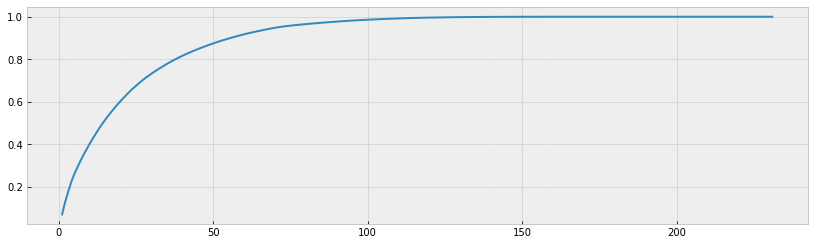

Number features: 70
Total Variance Explained: 0.9507685163008079


In [31]:
# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(vect_df)

# Plotting to determine how many features should the dataset be reduced to
plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,new_df.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = new_df.shape[1] - n_over_95

print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

In [32]:
# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(vect_df)

# Finding the exact number of features that explain at least 99% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_9 = len(total_explained_variance[total_explained_variance>=.99])
n_to_reach_9 = vect_df.shape[1] - n_over_9

print("PCA reduces the # of features from", vect_df.shape[1], 'to', n_to_reach_9)

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_9)

# Fitting and transforming the dataset to the stated number of features
df_pca = pca.fit_transform(vect_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
pca.explained_variance_ratio_.cumsum()[-1]

PCA reduces the # of features from 231 to 106


0.9899694592722716

----

Hierarchical Agglomerative Clustering:

In [33]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

In [34]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 11, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# The DF for evaluation
eval_df = df_pca

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    clust = AgglomerativeClustering(n_clusters=i, linkage='complete')
    clust.fit(eval_df)
    cluster_assignments = clust.labels_
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabasz_score(eval_df, cluster_assignments))
    s_scores.append(silhouette_score(eval_df, cluster_assignments))
    db_scores.append(davies_bouldin_score(eval_df, cluster_assignments))

In [35]:
def cluster_eval(y, x):
    """
    Prints the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('bmh')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

The Calinski-Harabasz Score (find max score):
Max Value:
Cluster #    Cluster Score
3       37.03276

Min Value:
Cluster #     Cluster Score
10      20.101704


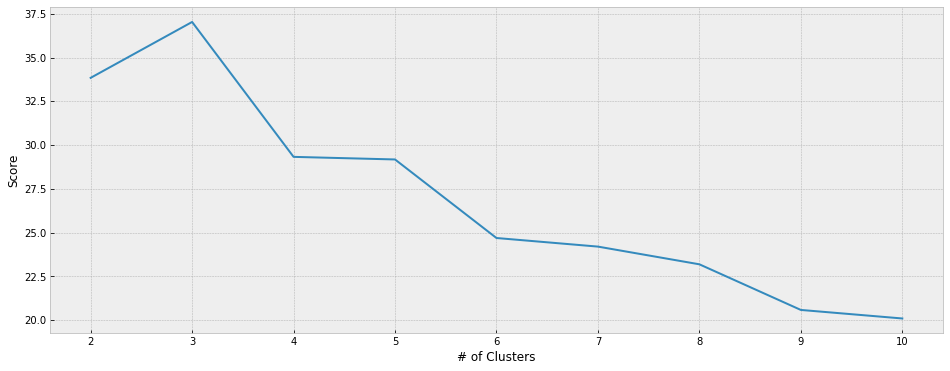


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
2       0.079041

Min Value:
Cluster #     Cluster Score
10       0.015375


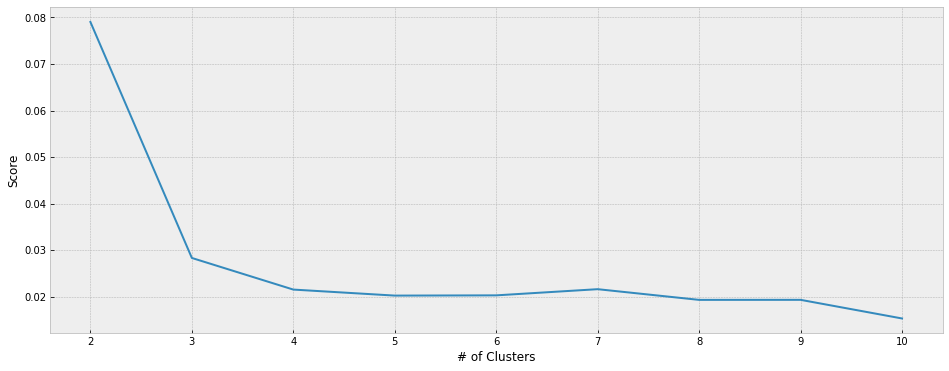


The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
3       5.083075

Min Value:
Cluster #    Cluster Score
9       3.647525


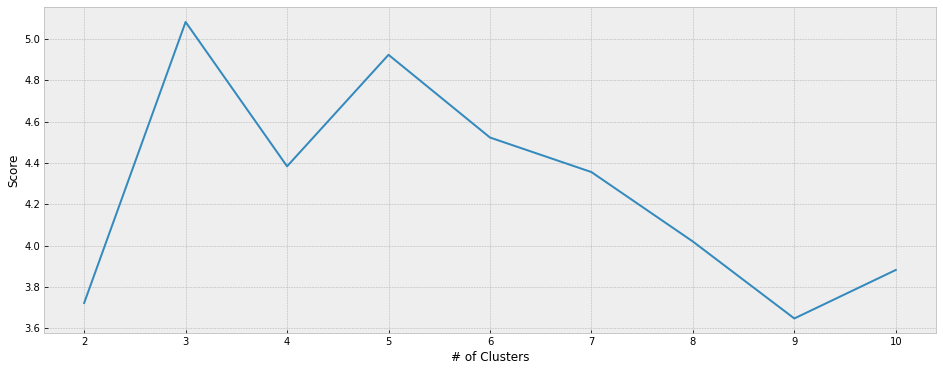

In [36]:
print("The Calinski-Harabasz Score (find max score):")
cluster_eval(ch_scores, cluster_cnt)

print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)

Visualizing scores given the number of clusters. Using ELBOW method we can figure out the ideal number of clusters.

In [37]:
# Instantiating HAC based on the optimum number of clusters found
hac = AgglomerativeClustering(n_clusters=5, linkage='complete')

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
asd['Cluster #'] = cluster_assignments

vect_df['Cluster #'] = cluster_assignments

----

Cluster column representing data points in the respective cluster.

In [38]:
asd['Cluster #']

0       2
1       2
2       1
3       2
4       1
       ..
1419    1
1420    2
1421    1
1422    1
1423    2
Name: Cluster #, Length: 1424, dtype: int64

----

In [39]:
asd.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job', 'offspring',
       'orientation', 'pets', 'sex', 'smokes', 'status', 'last_date_online',
       'last_time_online', 'year', 'month', 'day', 'city', 'language_1',
       'language_2', 'language_3', 'language_4', 'language_5', 'essay0_new',
       'essay1_new', 'essay2_new', 'essay3_new', 'essay4_new', 'essay5_new',
       'essay6_new', 'essay7_new', 'essay8_new', 'essay9_new', 'Cluster #'],
      dtype='object')

Goal: Find similar profiles based on clustering / tree based approaches and generate recommendations to the user to prevent ideal swiping on profiles leading up to no matches.

Basic pandas filtering: Based on APIs giving us user preference (while setting up their profiles), I thought I'd do a basic filtering to create a list of profiles which match their preferences.

In [40]:
ajeya_age = 26
city_pref = 'san francisco'
sex_pref = 'f'
orientation_pref = 'straight'
status_pref = 'single'

In [41]:
curarated_profile = asd[asd['city'] == city_pref]
curarated_profile = curarated_profile[curarated_profile['sex'] == sex_pref]
curarated_profile = curarated_profile[curarated_profile['orientation'] == orientation_pref]
curarated_profile = curarated_profile[curarated_profile['status'] == status_pref]

From the following dataframe, we can see that based on the most basic information obtained by OkCupid APIs about a user, we reduced the profile pool from 1424 records to just 131. This can be further filtered by matching TOPICS that profiles have in common (TOPICS obtained from Topic Modeling, representing similar interests). They can also be narrowed down by filtering profiles based on clusters which represent similar profiles based on their profile information.

In [42]:
curarated_profile

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,offspring,orientation,pets,sex,smokes,status,last_date_online,last_time_online,year,month,day,city,language_1,language_2,language_3,language_4,language_5,essay0_new,essay1_new,essay2_new,essay3_new,essay4_new,essay5_new,essay6_new,essay7_new,essay8_new,essay9_new,Cluster #
1,23,curvy,mostly anything,rarely,never,working on college/university,"hey im angel, heres a little about myself. i ...",discovering and exploring! finding myself. ta...,"art, math, learnin things fast, puzzles and br...",id say my hair and my eyes. i would say my smi...,favorite books are: my life as a teenage fairy...,"uumm, well music thats one, i love food but th...","everything; the world, what i can do for fun, ...",home happy to have some quite and a good movie...,sometimes i like to sit in the shower.. :) th...,"you are chill, nice, down to earth, educated, ...","black, native american, hispanic / latin",167.64,20000.0,other,has a kid,straight,likes dogs and likes cats,f,when drinking,single,2012-06-28,18:40:00,2012,6,28,san francisco,english,None,None,None,None,2,4,0,2,3,2,1,3,2,0,2
5,26,fit,mostly anything,socially,never,graduated from college/university,i recently moved to san francisco from london ...,im a civil engineer working in infrastructure....,"erm... holistic thinking? organising stuff, wi...",hmm dunno. id like to say my lovely smile? but...,"catch 22, lotr, war&amp;peace, anything by iai...","family, friends, books, music, sailing boats, ...",the most fun activity i can do for my evening ...,"happy hour or sailing, or running off to do so...",i miss home a lot but moving here is the brave...,youd like to meet up for a drink or a wander. ...,white,172.72,70000.0,science / tech / engineering,"doesn't have kids, but wants them",straight,likes dogs,f,no,single,2012-06-18,21:51:00,2012,6,18,san francisco,english,None,None,None,None,2,0,1,3,0,4,4,3,1,1,2
20,30,fit,mostly anything,rarely,sometimes,college/university,im pretty down to earth and happy with my life...,fulfilling the rudimentary needs of the people...,everything! period! but i specialize in cookin...,it depends on what youre drawn to. it might be...,food- i eat well. i have constant access for h...,-high quality organic food -good pot -great ...,"food, what to cook, how to cook it. i talk ...",smokin weed and going to bed at 8... (because ...,"im honest, ill answer any question youve got.","you are awesome, enjoy kickin it in the kitche...",white,167.64,40000.0,sales / marketing / biz dev,"doesn't have kids, and doesn't want any",straight,likes dogs and likes cats,f,no,single,2012-06-29,16:37:00,2012,6,29,san francisco,english,spanish,None,None,None,2,0,2,2,4,4,0,2,1,2,2
29,34,average,mostly anything,socially,sometimes,dropped out of space camp,im not a person that is in search of themselve...,stand up comedian. writer. video journalist....,"randomly singing, comedy, staying away from my...",the guy i buy my weed from at the medical stor...,food: i could fuck a vegan but not date one s...,comedy family friends food dinosaurs a hug,why the flintstones had a christmas episode.,at a comedy show. writing. hanging out with my...,im very hard to get because im picky as hell a...,"musts: you are funny, quick witted, polite, a...",white,162.56,40000.0,entertainment / media,doesn't want kids,straight,likes dogs and likes cats,f,no,single,2012-06-29,19:52:00,2012,6,29,san francisco,english,None,None,None,None,1,1,4,0,1,4,0,3,2,2,0
35,21,fit,mostly vegetarian,socially,never,working on two-year college,"im a sarcastic, laid back, nature lovin, and s...",making it my bitch,reciting the lyrics to kreyshawns masterpiece ...,"i studied at the milford academy as a youngn, ...","god bless you, mr. rosewater, big fish, stand ...","good food, sunshine, running, music, traveling...",if tupac really died,"dancing on table tops, taking too many shots, ...",anything

The dataframe above represents users that have filtered out on the basis on a user's preferences (assuming - an API gives us this data). This is just using simple concepts of pandas.

Future work: 

1. Now that clustering and topic modeling have been executed and we have similar profiles in under the same cluster, that information can be used to generate more accurate profiles.
2. Since different features contribute to a swipe in different ways, my idea for obtaining a better filtering process is to assign WEIGHTS to different features based on some predefined rules.
3. For eg: a user in San Francisco is most likely looking for a person who is in San Francisco (not everyone does long distance from scratch), so we can have profiles closest to SF having the heighest weights and assign lower weights to cities much farther from San Francisco. This can be done to almost all features (specially to essay responses - recommendig profiles with similar interests would be a huge factor in obtaining ideal recommendations).
4. Desing a new similarity measure that factors in rules (mentioned above), clustering and topic modeling to quanity the ideal profiles by generating a percentage that represents how well do the profiles match.

----

Data Analysis:

In [43]:
px.histogram(asd, x = 'age', color = 'city')

From the plot above we can observe that San Francisco has the most active users, followed by Oakland and Berkeley. This could be a great insight for the marketing team to generate positive advertisements to ensure customer retention maybe by offering promotions to active users. We also note a lot of cities do not have that many users which could help the marketing team in generating advertisments to obtain new customers.

In [44]:
px.histogram(asd, x = 'age', color = 'sex')

From the plot above we observe that # of females active users is much lesser than the # of active male users in California.

In [45]:
asd.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job', 'offspring',
       'orientation', 'pets', 'sex', 'smokes', 'status', 'last_date_online',
       'last_time_online', 'year', 'month', 'day', 'city', 'language_1',
       'language_2', 'language_3', 'language_4', 'language_5', 'essay0_new',
       'essay1_new', 'essay2_new', 'essay3_new', 'essay4_new', 'essay5_new',
       'essay6_new', 'essay7_new', 'essay8_new', 'essay9_new', 'Cluster #'],
      dtype='object')

In [46]:
px.histogram(asd, x = 'age', color = 'orientation')

In [47]:
px.histogram(asd, x = 'age', color = 'drinks')

Users visualized based on AGE and DRINKS preference. It is evident from the graph that most of the users do not drink. This just gives us an insight into the general population and this can help us recommend fun date ideas to users who actually do not prefer drinking (moving from the standard bar dates).

In [48]:
px.histogram(asd, x = 'age',  color = 'body_type')

Users visualized based on their AGE and BODY_TYPE.

In [49]:
px.histogram(asd, x = 'age', color='Cluster #')

The plot above shows us the distribution of age colored by the clusters they were assigned to. This can be further explored in clustering to visualize clusters better getting an idea of how similar profiles would fall under the same cluster (signifying similarities in profiles - making them ideal for recommendation).

Things achieved so far:

Future Steps:
1. More detailed EDA.
2. Recommend profiles based on clusters obtained from clustering.
3. Assign weights to features to add more depth to filtering / recommendation.
4. Get data with information on who swiped on whom or who matched with whom to implement Collaberative Filtering developing a recommendation engine. 

IF information on messages is made public, it would be interesting to see how loyal a user is (MONOGOMY), loyal in the sense that if they match with someone while they were talking to a match, would they switch to different users or would they start a new conversation ditching an already ongoing conversation.